# Decaying isomerization

The decaying isomerization process is the reversible interconversion of two isometric species $S_1$ and $S_2$ combined with the (typically much slower) decay of $S_2$ to a third spcies $S_3$:

$$ S_1 \leftrightarrows S_2 \qquad k_\text{forward} = c_1, k_\text{reverse} = c_2$$
$$ S_2 \to S_3 \qquad k = c_3 $$

As Rathinam [Rathinam 2003] and Gillespie [Gillespie 2008] note, for appropriately chosen parameters, the decaying isomerization problem is the simplest example of a "stiff" problem in chemical kinetics.

In the reversible isomerization process $ S_1 \leftrightarrows S_2$ alone, the random variable describing the number of $S_2$ specimens at equilibrium ($t \to \infty$) is:

$$ P(\# S_2 = x_2) = \text{Binomial}\left(\frac{c1}{c1 + c2}; x_T\right) (x_2) $$

where $x_T$ is the total inital specimens of $S_1$ and $S_2$ combined. (Gillespie 2008).

The relaxation time is defined as the characteristic time for the exponential approach of a perturbed system to its equilibrium. (The characteristic time being the time it takes for the exponential function to be reduced to a fraction $1/e$ of itself.)

In [11]:
import numpy as np
import pandas as pd
from reactionmodel.model import Species, Reaction, Model

In [27]:
S1 = Species('S1')
S2 = Species('S2')
S3 = Species('S3')

reactions = [
    Reaction([S1], [S2], k='c1'),
    Reaction([S2], [S1], k='c2')
]

m = Model([S1, S2], reactions)

reactions.append(
    Reaction([S2], [S3], k='c3')
)

m_decay = Model([S1, S2, S3], reactions)

p = {'c1': 1, 'c2':1}
p_decay = {'c1': 1.0, 'c2': 2.0, 'c3': 5 * 1e-5} # gillespie 2008 figure 5

t_span = [0.0, 5000]

initial_dictionary = {'S1': 1200, 'S2': 600, 'S3':0}

ic = m_decay.make_initial_condition(initial_dictionary)

def end_routine(result):
    return m_decay.y_to_dict(result.y)

## Slow-scale stochastic simulation

In [14]:
S12 = Species('S12')
S3  = Species('S3')

reactions = [
    Reaction([S12], [S3], k='c1*c3/(c1+c2)')
]

m_ss = Model([S12, S3], reactions)

ic_ss = m_ss.make_initial_condition({'S12': initial_dictionary['S1']+initial_dictionary['S2'], 'S3': initial_dictionary['S3']})

def sample_y(y_ss, m, p):
    y_dict = {}
    y_ss_dict = m.y_to_dict(y_ss)
    y_dict['S3'] = y_ss_dict['S3']
    y_dict['S2'] = np.random.binomial(y_ss_dict['S12'], p['c1']/(p['c1'] + p['c2']))
    y_dict['S1'] = y_ss_dict['S12'] - y_dict['S2']
    return y_dict

In [4]:
from hybrid.gillespie import GillespieSimulator

g_ss = GillespieSimulator(
    m_ss.get_k(parameters=p_decay, jit=True),
    m_ss.stoichiometry(),
    m_ss.kinetic_order(),
)

Evaluating expression: c1*c3/(c1+c2) => 1.6666666666666667e-05


In [19]:
def ss_end_routine(result):
    return sample_y(result.y, m_ss, p_decay)

ss_df = pd.DataFrame(g_ss.run_simulations(2000, t_span, ic_ss, np.random.default_rng(), end_routine=ss_end_routine))
ss_df

,S3,S2,S1
0,160.0,542,1098.0
1,139.0,580,1081.0
2,146.0,545,1109.0
3,137.0,576,1087.0
4,136.0,556,1108.0
...,...,...,...
1995,152.0,539,1109.0
1996,153.0,544,1103.0
1997,149.0,556,1095.0
1998,141.0,549,1110.0


<Axes: >

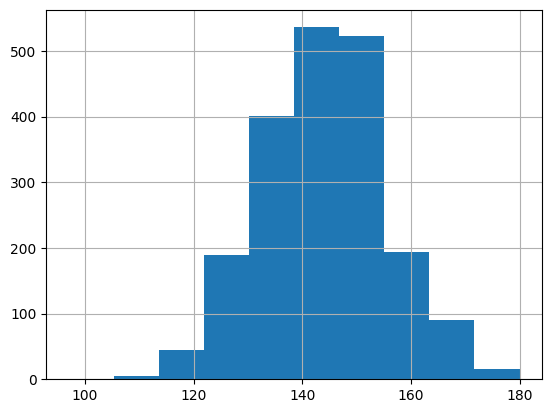

In [23]:
ss_df['S3'].hist()

## Tau leaping

In [28]:
from hybrid.tau import TauLeapSimulator

t_s = TauLeapSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
    epsilon=0.1
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 5e-05


In [30]:
tau_df = pd.DataFrame(t_s.run_simulations(10, t_span, ic, np.random.default_rng(), end_routine=end_routine))

<Axes: >

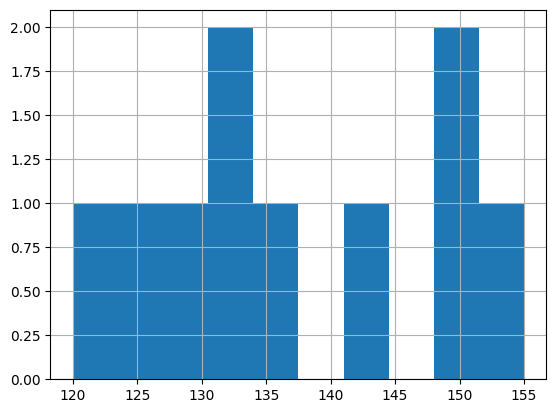

In [33]:
tau_df['S3'].hist()

In [31]:
result = t_s.simulate(t_span, ic, np.random.default_rng())

,S1,S2,S3
0,1067.0,602.0,131.0
1,1134.0,534.0,132.0
2,1117.0,542.0,141.0
3,1111.0,541.0,148.0
4,1113.0,532.0,155.0
5,1084.0,596.0,120.0
6,1154.0,509.0,137.0
7,1167.0,504.0,129.0
8,1180.0,494.0,126.0
9,1135.0,516.0,149.0


Counter({<TauStepStatus.leap: 0>: 6748})

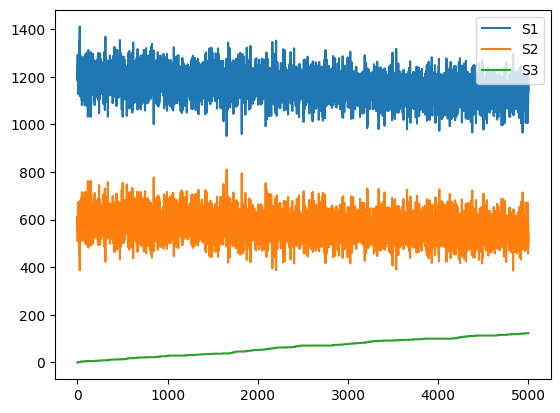

In [26]:
result.plot(m_decay.legend())
result.status_counter

In [27]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

h_s = HybridSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 5e-05


In [ ]:
hybrid_df = pd.DataFrame(h_s.run_simulations(10, t_span, ic, np.random.default_rng(), end_routine=end_routine))

<Axes: >

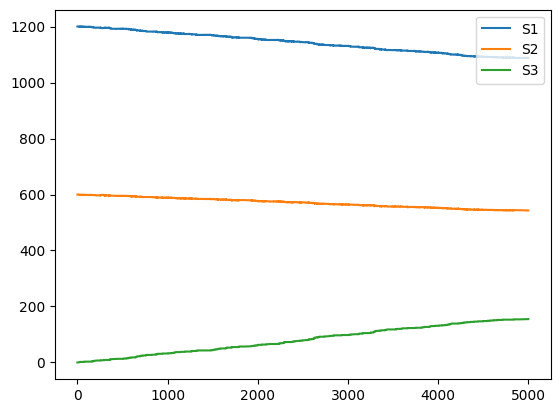

In [30]:
result = h_s.simulate(t_span, ic, np.random.default_rng())
result.plot(m_decay.legend())

# Immigration + linear death process

In [74]:
from reactionmodel.model import Species, Reaction, Model
from hybrid.gillespie import GillespieSimulator

S1 = Species('S1')

reactions = [
    Reaction([S1], [], k='r'),
    Reaction([], [S1], k='p')
]

m = Model([S1], reactions)

p = {'r': 1, 'p':100}

s = GillespieSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

Evaluating expression: r => 1.0
Evaluating expression: p => 100.0


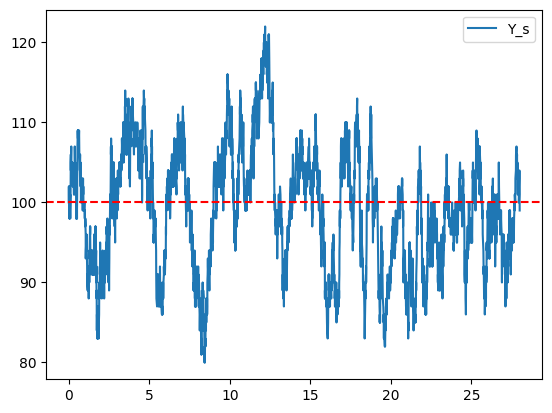

In [80]:
import numpy as np
result = s.simulate([0.0, 28.0], m.make_initial_condition({'S1': 100}), np.random.default_rng())
ax = result.plot(['Y_s'])
ax.axhline(100, color='r', linestyle='dashed')

In [10]:
import matplotlib.pyplot as plt
#plt.hist(result.y_history)

In [11]:
import pandas as pd
r = pd.DataFrame(data={'S': np.squeeze(result.y_history.T)})
r

,S
0,100.0
1,101.0
2,100.0
3,101.0
4,100.0
...,...
601129,99.0
601130,100.0
601131,101.0
601132,100.0


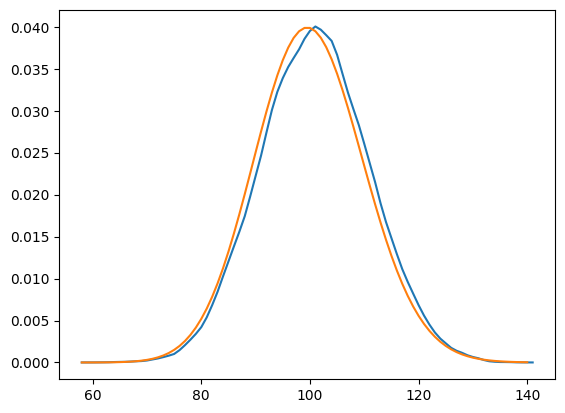

In [12]:
import scipy.stats

ax = plt.subplot()
x = np.arange(r.min().iloc[0], r.max().iloc[0])

ax.plot([x[0] for x in r.value_counts(normalize=True).sort_index().index.to_numpy()], r.value_counts(normalize=True).sort_index().to_numpy())
#ax = r.value_counts(normalize=True).sort_index().plot()

rv = scipy.stats.poisson(p['p']/p['c1'])
ax.plot(x, rv.pmf(x))

# Simple experiment idea:

Let's say you have a latent reservoir of size $n$ with variance $v$. As a function of the variance in the reservoir size, how much variance is there in the time until you hit exponential growth? How much variation is there in the re-seeded latent reservoir after a phase of $R_0$ that lasts for $t$ days?

=> how does this translate to your conclusions about probability of mutant emergence given a set standard?
=> how 